In [128]:
import sys
from os import P_ALL
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
import seaborn as sns
import logging
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer
from scipy.stats import zscore
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error

# **importing scripts**

In [129]:
sys.path.append('/content/drive/MyDrive/store-sales-analysis/scripts')
import Exploratory_data_analysis as EDA

# **Loading Datasets**

In [130]:
file_path_train = '/content/drive/MyDrive/store-sales-analysis/data/train.csv'
file_path_test = '/content/drive/MyDrive/store-sales-analysis/data/test.csv'
file_path_store = '/content/drive/MyDrive/store-sales-analysis/data/store.csv'

train = EDA.load_data(file_path_train)
test = EDA.load_data(file_path_test)
store = EDA.load_data(file_path_store)

data loaded successfully.
data loaded successfully.
data loaded successfully.


/content/drive/MyDrive/store-sales-analysis/scripts/Exploratory_data_analysis.py:8: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


# **Summerize Datasets**

In [131]:
for df in [train, test, store]:
    EDA.summarize_data(df)


 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB
None

 First 5 Rows:
   Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1      

# **Handling missing values**

In [132]:
for df in [train, test, store]:
    EDA.handle_missing_values(df)

Missing values handled successfully.
Missing values handled successfully.
Missing values handled successfully.


# **Data Distribution**

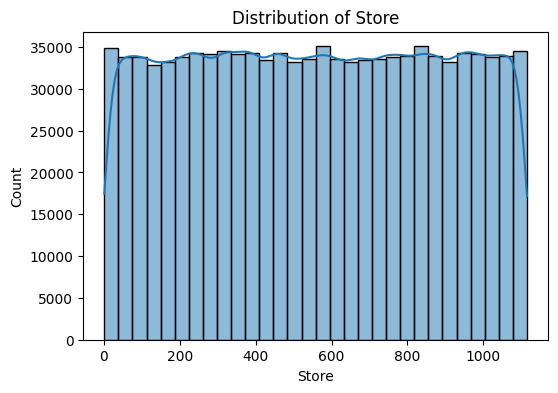

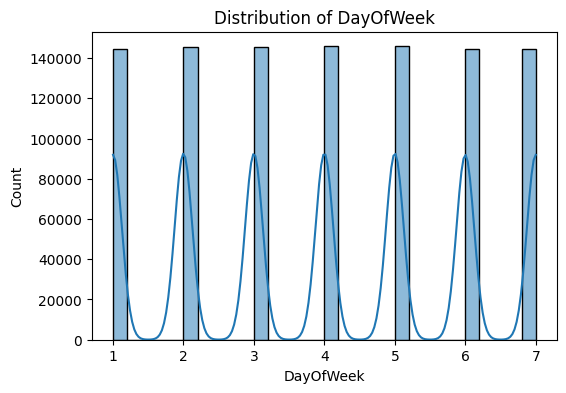

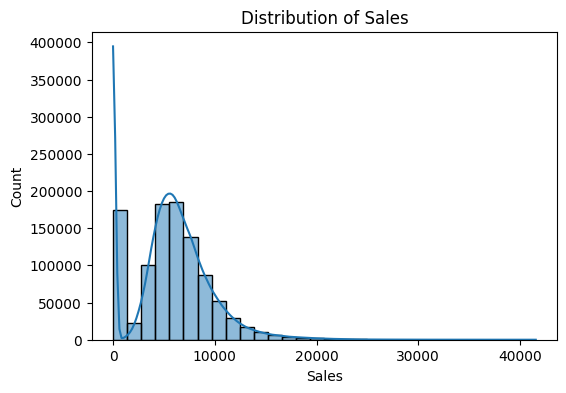

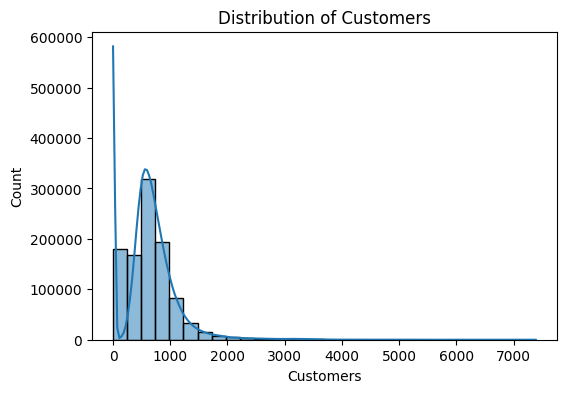

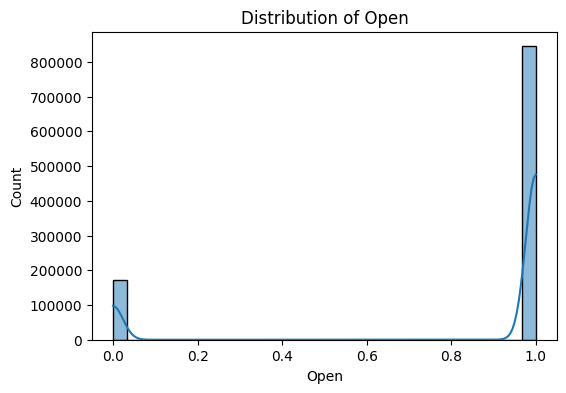

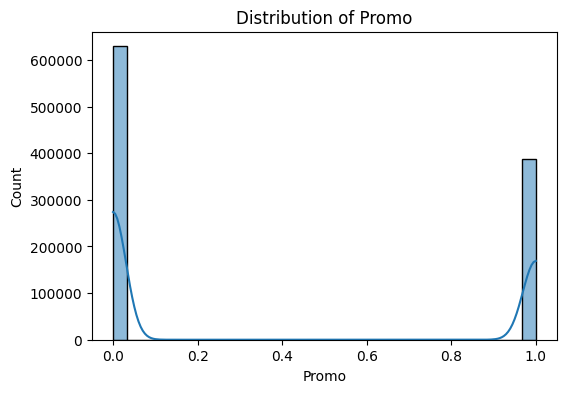

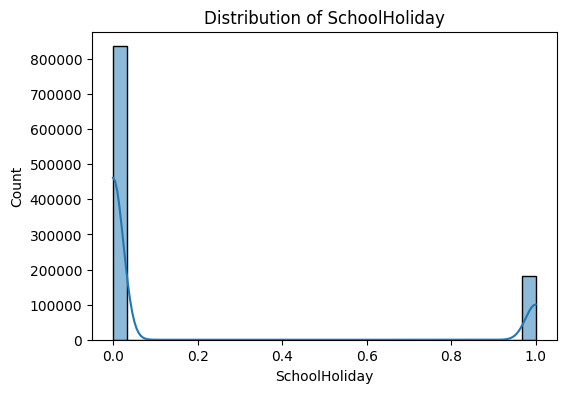

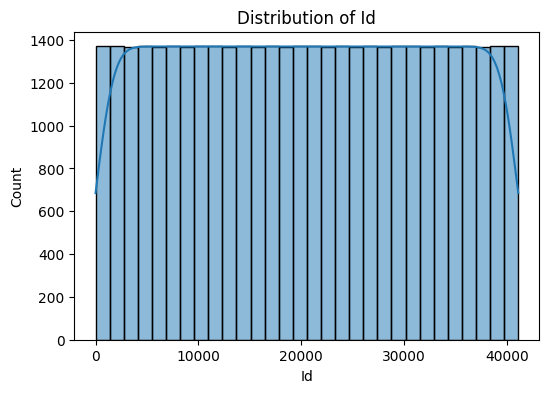

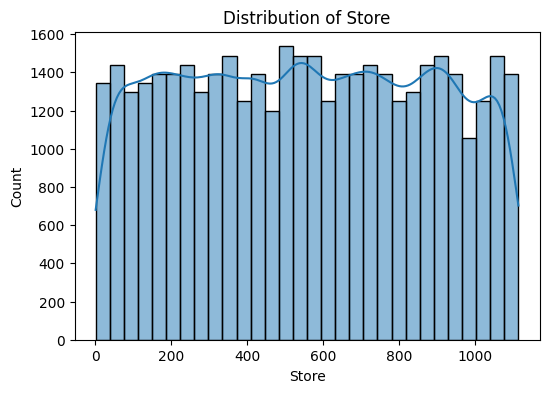

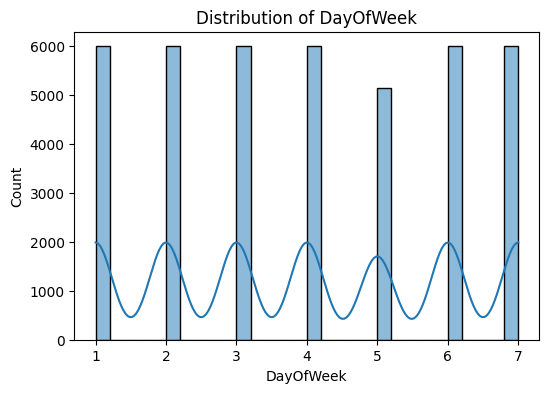

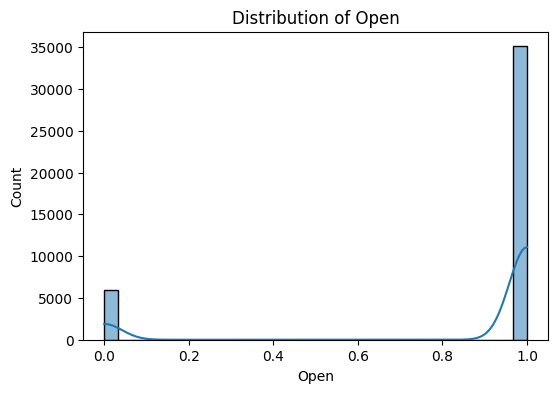

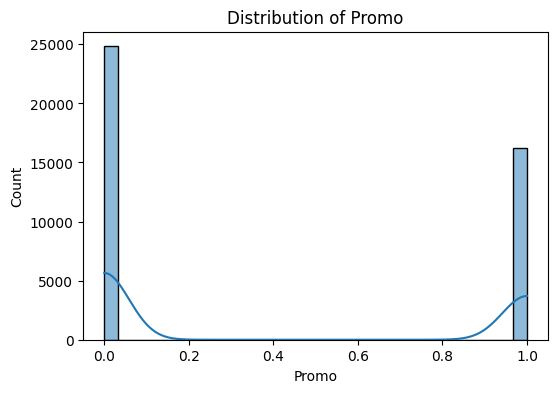

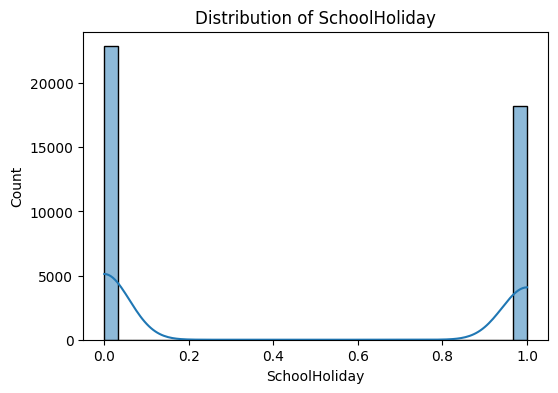

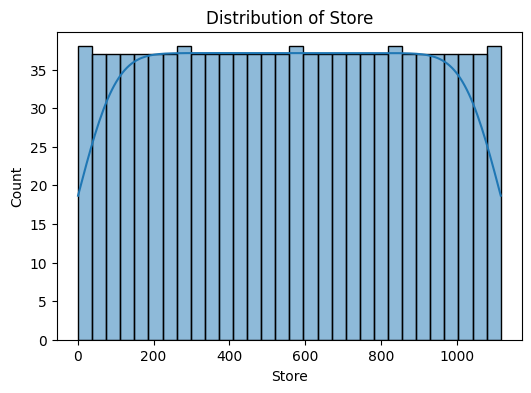

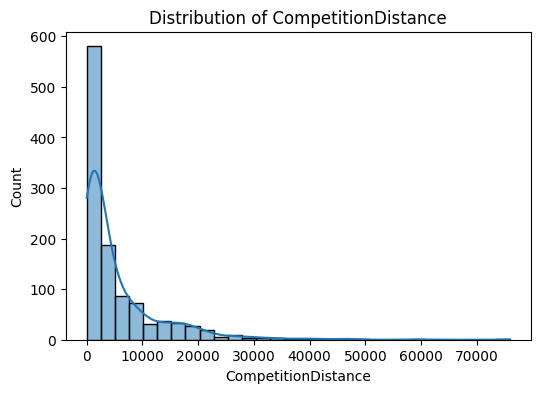

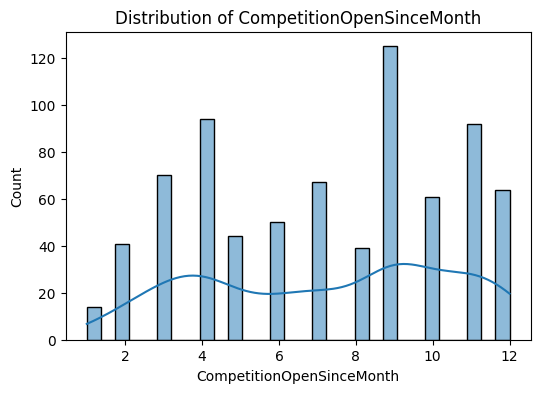

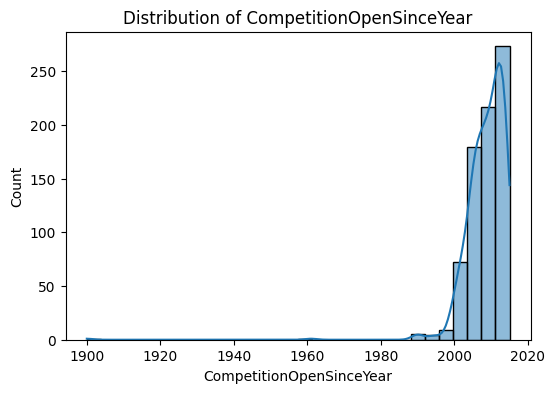

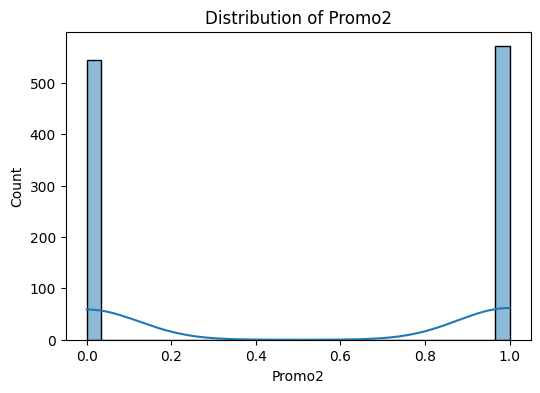

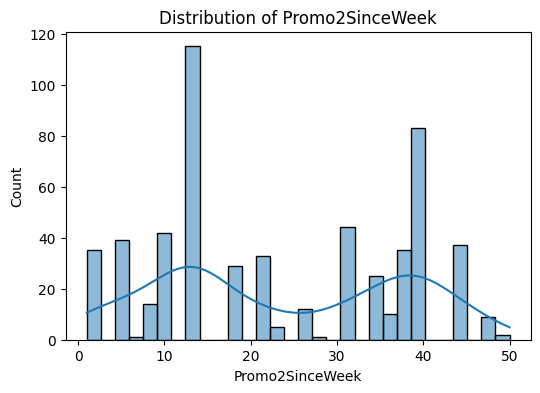

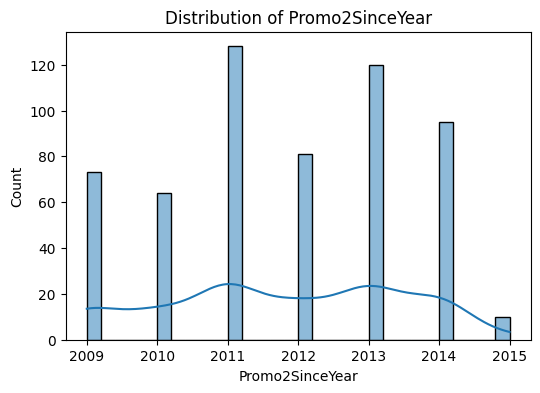

In [133]:
for df in [train, test, store]:
    EDA.plot_distributions(df)

# **Checks skewness and applies transformation if data is highly skewed.**

# **Correlation**